# CNN Image Classification Assignment: Fashion MNIST

## Problem Description

In this assignment, you will build a Convolutional Neural Network (CNN) to classify images from the Fashion MNIST dataset. This dataset consists of 70,000 grayscale images in 10 categories and is considered to be more challenging than the original MNIST dataset.

## Dataset

Fashion MNIST dataset:
- 60,000 training images
- 10,000 test images
- 10 classes of clothing items
- Image size: 28x28 pixels (grayscale)

For more information, refer to this link: [Fashion MNIST Dataset](https://github.com/zalandoresearch/fashion-mnist)

## Assignment Tasks

1. Data Preparation
   - Normalize the pixel values
   - Split the data into training and validation sets

2. Model Architecture
   - Design a CNN with at least 2 convolutional layers and 1 dense layer
   - Include appropriate activation functions, pooling layers, and a flatten layer

3. Model Compilation
   - Choose an appropriate optimizer and loss function
   - Select accuracy as the metric to monitor

4. Model Training
   - Train the model for at least 10 epochs
   - Use a validation split to monitor for overfitting

5. Model Evaluation
   - Evaluate the model on the test set
   - Plot the training and validation accuracy/loss curves

6. Predictions and Visualization
   - Make predictions on a few test images
   - Visualize these images along with their predicted and actual labels

# Assignment Code Section

In [1]:
# import the necessary packages
%pip install ipytest pytest
import os
import requests
import gzip
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ipytest
import pytest

ipytest.autoconfig()

# add the necessary imports as needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.3/342.3 kB 6.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Do not modify this cell

# dictionary to store the methods
FashionMNISTClassifier = {}

In [3]:
# Do not modify this cell
def __init__(data_dir='data'):
    """
    Initializes the FashionMNISTClassifier object with default values.

    Args:
        data_dir (str): The directory where the data is stored. Default is 'data'.

    Attributes:
        model (None): Placeholder for the model object.
        history (None): Placeholder for the history object.
        x_train (None): Placeholder for the training data.
        y_train (None): Placeholder for the training labels.
        x_test (None): Placeholder for the testing data.
        y_test (None): Placeholder for the testing labels.
        predictions (None): Placeholder for the predictions.
        data_dir (str): Directory where the data is stored.
        class_names (list): List of class names for the Fashion MNIST dataset.
        runtime_device (str): The device (CPU/GPU) on which the model will run, detected and set by the `detect_and_set_device` method.
    """
    self = {
        'model': None, # model object
        'history': None, # history object
        'x_train': None, # training data
        'y_train': None, # training labels
        'x_test': None, # testing data
        'y_test': None, # testing labels
        'predictions': None, # predictions
        'data_dir': data_dir, # data directory
        'class_names': ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # class names
    }
    self['runtime_device'] = FashionMNISTClassifier['detect_and_set_device'](self) # detect and set device
    return self

# add the method to the dictionary
FashionMNISTClassifier['__init__'] = __init__

In [4]:
# Do not modify this cell
def detect_and_set_device(self):
    """
    Detects if a GPU is available and sets the device accordingly.
    This function checks if TensorFlow is built with CUDA support and if any 
    physical GPU devices are available. If a GPU is available, it attempts to 
    set memory growth for each GPU to prevent TensorFlow from allocating all 
    the GPU memory at once. If successful, it returns 'GPU'. If there is an 
    error in setting memory growth, it prints an error message and returns 'CPU'.
    If no GPU is available, it defaults to using the CPU.
    Returns:
        str: 'GPU' if a GPU is available and memory growth is set successfully, 
             otherwise 'CPU'.
    """
    if tf.test.is_built_with_cuda():
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            print("GPU is available. Using GPU.")
            try:
                for gpu in physical_devices:
                    tf.config.experimental.set_memory_growth(gpu, True)
                return 'GPU'
            except RuntimeError as e:
                print(f"Unable to set memory growth: {e}")
                return 'CPU'
    
    print("GPU is not available. Using CPU.")
    return 'CPU'

FashionMNISTClassifier['detect_and_set_device'] = detect_and_set_device

In [5]:
# Do not modify this cell
def download_fashion_mnist(self):
    """
    Downloads the Fashion MNIST dataset if it does not already exist in the specified directory.
    This function checks for the existence of the dataset files in the directory specified by `self['data_dir']`.
    If the files are not found, it downloads them from the provided URLs and saves them in the directory.
    Args:
        self (dict): A dictionary containing configuration parameters, including 'data_dir' which specifies the directory to save the dataset.
    Raises:
        OSError: If there is an issue creating the directory or writing the files.
    Prints:
        Status messages indicating the progress of the download and completion.
    """
    urls = [
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz'
    ]
    
    if not os.path.exists(self['data_dir']):
        os.makedirs(self['data_dir'])
    
    for url in urls:
        filename = url.split('/')[-1]
        filepath = os.path.join(self['data_dir'], filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            r = requests.get(url, allow_redirects=True)
            open(filepath, 'wb').write(r.content)
    
    print('Fashion MNIST dataset downloaded successfully!')

FashionMNISTClassifier['download_fashion_mnist'] = download_fashion_mnist

In [6]:
# Do not modify this cell
def load_data(self):
    """
    Loads the Fashion MNIST dataset from the specified data directory.
    This function checks if the required dataset files are present in the 
    specified data directory. If any of the files are missing, it triggers 
    the download of the Fashion MNIST dataset. It then loads the images and 
    labels from the compressed files and reshapes the images to the required 
    format.
    Attributes:
        self (dict): A dictionary containing configuration and data paths.
    Raises:
        FileNotFoundError: If any of the dataset files are missing and the 
                           download fails.
    Side Effects:
        Updates the following keys in the `self` dictionary:
        - 'x_train': Training images, reshaped to (-1, 28, 28, 1).
        - 'y_train': Training labels.
        - 'x_test': Test images, reshaped to (-1, 28, 28, 1).
        - 'y_test': Test labels.
    """
    files = [
        'train-images-idx3-ubyte.gz',
        'train-labels-idx1-ubyte.gz',
        't10k-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz'
    ]
    
    if not all(os.path.exists(os.path.join(self['data_dir'], f)) for f in files):
        FashionMNISTClassifier['download_fashion_mnist'](self)

    def load_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        return data.reshape(-1, 28, 28, 1)

    def load_labels(filename):
        with gzip.open(filename, 'rb') as f:
            return np.frombuffer(f.read(), np.uint8, offset=8)

    self['x_train'] = load_images(os.path.join(self['data_dir'], 'train-images-idx3-ubyte.gz'))
    self['y_train'] = load_labels(os.path.join(self['data_dir'], 'train-labels-idx1-ubyte.gz'))
    self['x_test'] = load_images(os.path.join(self['data_dir'], 't10k-images-idx3-ubyte.gz'))
    self['y_test'] = load_labels(os.path.join(self['data_dir'], 't10k-labels-idx1-ubyte.gz'))

FashionMNISTClassifier['load_data'] = load_data

In [7]:
# Write your code here: Do the preprocessing steps

def preprocess_data(self):
    """
    Preprocesses the dataset by normalizing image data and reshaping label data.
    This function performs the following steps:
    1. Normalizes the image data (`x_train` and `x_test`) to the range [0, 1].
    2. Reshapes the label data (`y_train` and `y_test`) to ensure they are in the correct shape.
    After preprocessing, the function prints the shapes of the training and test datasets.
    Attributes:
        self (dict): A dictionary containing the dataset with keys 'x_train', 'x_test', 'y_train', and 'y_test'.
    Prints:
        Training data shape: Shape of the training images.
        Training labels shape: Shape of the training labels.
        Test data shape: Shape of the test images.
        Test labels shape: Shape of the test labels.
    """
    
    # Write your code here
    
    print("Training data shape:", self['x_train'].shape)
    print("Training labels shape:", self['y_train'].shape)
    print("Test data shape:", self['x_test'].shape)
    print("Test labels shape:", self['y_test'].shape)

# Do not modify this
FashionMNISTClassifier['preprocess_data'] = preprocess_data

In [8]:
# Write your code here: Define the create_model method
def create_model(self):
    """
    Creates and compiles a Convolutional Neural Network (CNN) model using TensorFlow's Keras API.

    Args:
        self (dict): A dictionary to store the created model under the key 'model'.

    Returns:
        None
    """
    # Write your code here: create the model

# Do not modify this
FashionMNISTClassifier['create_model'] = create_model

In [9]:
# Write your code here: Define the train_model method
def train_model(self):
    """
    Trains the model using the provided training data.

    Args:
        epochs (int, optional): Number of epochs to train the model. Defaults to 10.
        validation_split (float, optional): Fraction of the training data to be used as validation data. Defaults to 0.2.

    Returns:
        None
    """
    # Write your code here: Define the hyperparameters and train the model, modify the fit method below as per the hyperparameters
    with tf.device('/' + self['runtime_device'] + ':0'):
        self['history'] = self['model'].fit(
            self['x_train'], self['y_train'], 
        )

# Do not modify this
FashionMNISTClassifier['train_model'] = train_model

In [10]:
# Write your code here: Define the evaluate_model method
def evaluate_model(self):
    """
    Evaluates the model on the test dataset and prints the test accuracy.

    This method uses the runtime device specified in the instance to evaluate
    the model's performance on the test data. It prints the test accuracy after
    evaluation.

    Args:
        self: An instance of the class containing the following attributes:
            - runtime_device (str): The device to run the evaluation on (e.g., 'cpu', 'gpu').
            - model (tf.keras.Model): The trained model to be evaluated.
            - x_test (numpy.ndarray or tf.Tensor): The test data features.
            - y_test (numpy.ndarray or tf.Tensor): The test data labels.

    Returns:
        None
    """
    # Write your code here: Evaluate the model on the test data, modify the evaluate method below as per the hyperparameters
    with tf.device('/' + self['runtime_device'] + ':0'):
        test_loss, test_acc = self['model'].evaluate()
        print(f'\nTest accuracy: {test_acc}')
        print(f'Test loss: {test_loss}')

# Do not modify this
FashionMNISTClassifier['evaluate_model'] = evaluate_model

In [11]:
# Write your code here: Define the make_predictions method
def make_predictions(self):
    """
    Generates predictions using the model and test data.

    This method sets the device context to the specified runtime device and 
    uses the model to predict the outcomes for the test data. The predictions 
    are then stored in the 'predictions' attribute of the instance.

    Attributes:
        self['runtime_device'] (str): The device to run the prediction on (e.g., 'cpu', 'gpu').
        self['model'] (tf.keras.Model): The trained model used for making predictions.
        self['x_test'] (numpy.ndarray): The test data on which predictions are to be made.
        self['predictions'] (numpy.ndarray): The predicted outcomes for the test data.
    """
    # Write your code here: Make predictions on the test data, modify the predict method below
    with tf.device('/' + self['runtime_device'] + ':0'):
        self['predictions'] = self['model'].predict()

# Do not modify this
FashionMNISTClassifier['make_predictions'] = make_predictions

In [12]:
# Do not modify this cell

def plot_training_history(self):
    """
    Plots the training and validation accuracy and loss over epochs.

    This function creates a figure with two subplots:
    - The first subplot shows the training and validation accuracy over epochs.
    - The second subplot shows the training and validation loss over epochs.

    The function assumes that the training history is stored in the 'history' attribute of the object.

    Parameters:
    self (object): The object containing the training history in the 'history' attribute.

    Returns:
    None
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(self['history'].history['accuracy'], label='Training Accuracy')
    plt.plot(self['history'].history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(self['history'].history['loss'], label='Training Loss')
    plt.plot(self['history'].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

FashionMNISTClassifier['plot_training_history'] = plot_training_history

In [13]:
# Do not modify this cell

def plot_predictions(self, num_rows=5, num_cols=3):
    """
    Plots a grid of predictions made by the FashionMNISTClassifier.

    Args:
        num_rows (int, optional): Number of rows in the grid. Defaults to 5.
        num_cols (int, optional): Number of columns in the grid. Defaults to 3.

    The function creates a figure with a specified number of rows and columns,
    and plots the images along with their predicted labels. The images are 
    displayed in a grid format using matplotlib.

    Note:
        This function assumes that the FashionMNISTClassifier has a method 
        'plot_image' that takes the classifier instance and an index as arguments.
    """
    num_images = num_rows * num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        FashionMNISTClassifier['plot_image'](self, i)
    plt.tight_layout()
    plt.show()

FashionMNISTClassifier['plot_predictions'] = plot_predictions


In [14]:
# Do not modify this cell
def plot_image(self, i):
    """
    Plots a single image from the test dataset along with its predicted and true labels.
    Args:
        self: An object containing the test dataset, predictions, and class names.
        i (int): The index of the image to be plotted.
    The function displays the image with no grid and no axis ticks. The image is reshaped to 28x28 pixels and displayed in binary color map. 
    The predicted label is shown in blue if it matches the true label, otherwise in red. The label also includes the prediction confidence percentage.
    """
    true_label, img = self['y_test'][i], self['x_test'][i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((28,28)), cmap=plt.cm.binary)
    predicted_label = np.argmax(self['predictions'][i])
    
    true_label = int(true_label)  
    
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(self['class_names'][predicted_label],
                                         100*np.max(self['predictions'][i]),
                                         self['class_names'][true_label]),
                                         color=color)
    
FashionMNISTClassifier['plot_image'] = plot_image

GPU is not available. Using CPU.
Fashion MNIST dataset downloaded successfully!
Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000, 1)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000, 1)
Epoch 1/10


/Users/shashwatshahi/Desktop/GEN-AI/CNN/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7508 - loss: 0.7006 - val_accuracy: 0.8652 - val_loss: 0.3760
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8764 - loss: 0.3437 - val_accuracy: 0.8851 - val_loss: 0.3174
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8938 - loss: 0.2899 - val_accuracy: 0.8977 - val_loss: 0.2853
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9061 - loss: 0.2536 - val_accuracy: 0.9018 - val_loss: 0.2726
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9170 - loss: 0.2250 - val_accuracy: 0.9007 - val_loss: 0.2684
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9232 - loss: 0.2103 - val_accuracy: 0.9103 - val_loss: 0.2526
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9282 - loss: 0.1874 - val_accuracy: 0.9052 - val_loss: 0.2666
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9379 - loss: 0.1648 - val

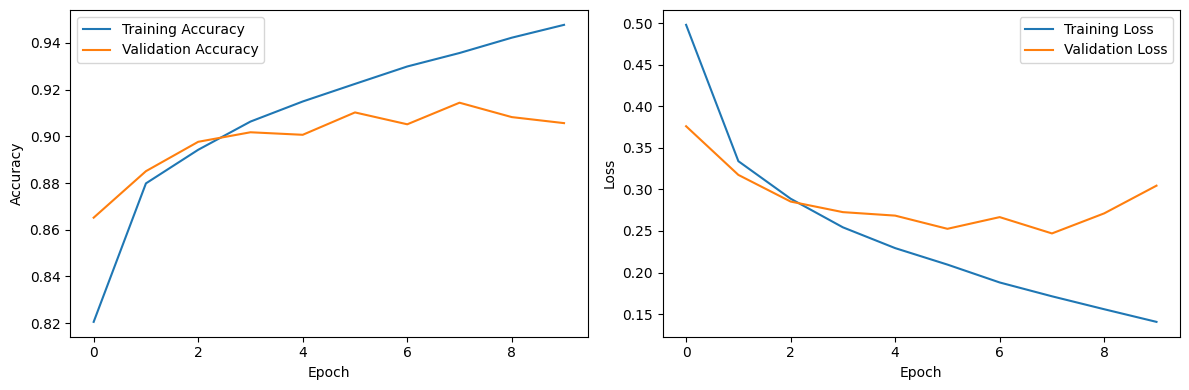

/var/folders/xh/n2zwv_lj64dbxt88d95qh0880000gn/T/ipykernel_15645/2083506049.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(true_label)


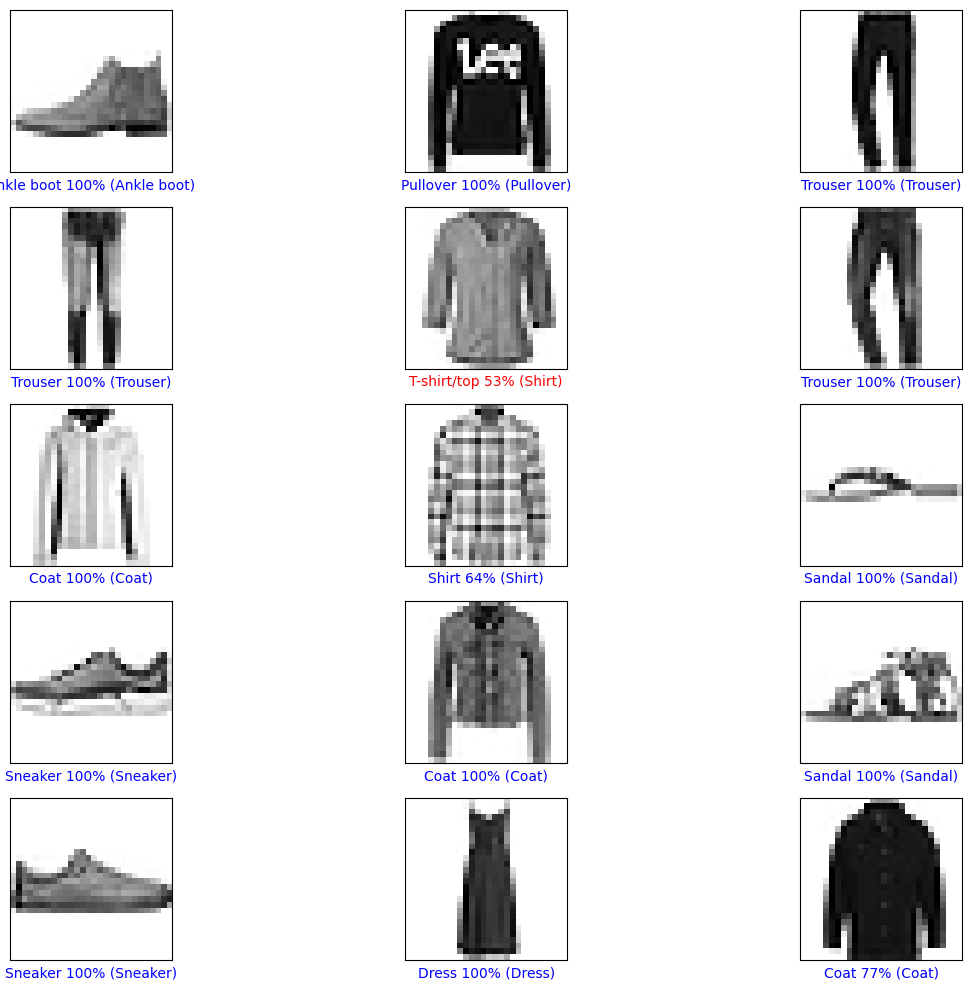

In [15]:
# Do not modify this cell
def run_classifier():
    """
    Executes the sequence of steps to run the FashionMNISTClassifier.
    This function performs the following steps:
    1. Initializes the FashionMNISTClassifier.
    2. Loads the Fashion MNIST dataset.
    3. Preprocesses the dataset.
    4. Creates the model architecture.
    5. Trains the model on the training data.
    6. Evaluates the model on the test data.
    7. Makes predictions using the trained model.
    8. Plots the training history.
    9. Plots the predictions.
    Returns:
        None
    """
    classifier = FashionMNISTClassifier['__init__']()
    
    FashionMNISTClassifier['load_data'](classifier)
    FashionMNISTClassifier['preprocess_data'](classifier)
    FashionMNISTClassifier['create_model'](classifier)
    FashionMNISTClassifier['train_model'](classifier)
    FashionMNISTClassifier['evaluate_model'](classifier)
    FashionMNISTClassifier['make_predictions'](classifier)
    FashionMNISTClassifier['plot_training_history'](classifier)
    FashionMNISTClassifier['plot_predictions'](classifier)

# Run the classifier
run_classifier()

In [16]:
# Do not modify this cell
class TestFashionMNISTClassifier:
    """TestFashionMNISTClassifier is a test suite for the FashionMNISTClassifier class.
    This test suite includes the following tests:
    1. test_load_data: Verifies that the load_data method correctly loads the training and test datasets.
    2. test_preprocess_data: Ensures that the data is properly preprocessed and normalized.
    3. test_create_model: Checks that the model is created with the required layers.
    4. test_train_model: Tests the training process and verifies that training and validation accuracies are recorded.
    5. test_evaluate_model: Evaluates the model and ensures that it has metrics after evaluation.
    6. test_make_predictions: Tests the entire prediction pipeline and ensures that predictions are made.
    Each test method uses the classifier fixture to initialize an instance of the FashionMNISTClassifier and performs specific checks to validate the functionality of the classifier."""
    @pytest.fixture
    def classifier(self):
        """
        Initializes and returns an instance of the FashionMNISTClassifier.

        Returns:
            FashionMNISTClassifier: An instance of the FashionMNISTClassifier class.
        """
        return FashionMNISTClassifier['__init__']()

    def test_load_data(self, classifier):
        """
        Tests the load_data method of the FashionMNISTClassifier.

        This method verifies that the load_data method correctly loads the training 
        and test datasets into the classifier. It asserts that the training data 
        (x_train), training labels (y_train), test data (x_test), and test labels 
        (y_test) are not None after loading.

        Args:
            self: The instance of the test class.
            classifier (dict): The classifier object which should contain the 
                               datasets after calling load_data.

        Raises:
            AssertionError: If any of the datasets (x_train, y_train, x_test, y_test) 
                            are None after loading.
        """
        FashionMNISTClassifier['load_data'](classifier)
        assert classifier['x_train'] is not None, "Training data should not be None"
        assert classifier['y_train'] is not None, "Training labels should not be None"
        assert classifier['x_test'] is not None, "Test data should not be None"
        assert classifier['y_test'] is not None, "Test labels should not be None"

    def test_preprocess_data(self, classifier):
        """
        Tests the preprocessing of data for the FashionMNISTClassifier.

        This method performs the following checks:
        1. Ensures that the training data is loaded and preprocessed.
        2. Ensures that the test data is loaded and preprocessed.
        3. Asserts that the maximum value in the training data is less than or equal to 1.0.
        4. Asserts that the maximum value in the test data is less than or equal to 1.0.
        5. Asserts that the minimum value in the training data is greater than or equal to 0.0.
        6. Asserts that the minimum value in the test data is greater than or equal to 0.0.

        Parameters:
        self (object): The instance of the test class.
        classifier (dict): A dictionary representing the FashionMNISTClassifier with keys 'x_train' and 'x_test' for training and test data respectively.

        Raises:
        AssertionError: If any of the assertions fail, indicating that the data is not properly normalized.
        """
        FashionMNISTClassifier['load_data'](classifier)
        FashionMNISTClassifier['preprocess_data'](classifier)
        assert np.max(classifier['x_train']) <= 1.0, "Training data should be normalized"
        assert np.max(classifier['x_test']) <= 1.0, "Test data should be normalized"
        assert np.min(classifier['x_train']) >= 0.0, "Training data should be normalized"
        assert np.min(classifier['x_test']) >= 0.0, "Test data should be normalized"

    def test_create_model(self, classifier):
        """
        Test the creation of the model in the FashionMNISTClassifier.
        This test verifies that the `create_model` method of the FashionMNISTClassifier
        successfully creates a model with the following properties:
        - The model is not None.
        - The model has at least 4 layers.
        - The model includes at least one Conv2D layer.
        - The model includes at least one Dense layer.
        - The model includes a Flatten layer.
        Args:
            classifier (dict): A dictionary containing the classifier and its components.
        Raises:
            AssertionError: If any of the above conditions are not met.
        """
        FashionMNISTClassifier['create_model'](classifier)
        model = classifier['model']
        assert model is not None, "Model should be created"
        assert len(model.layers) >= 4, "Model should have at least 4 layers"
        
        layer_types = [type(layer).__name__ for layer in model.layers]
        assert 'Conv2D' in layer_types, "Model should have at least one Conv2D layer"
        assert 'Dense' in layer_types, "Model should have at least one Dense layer"
        assert 'Flatten' in layer_types, "Model should have a Flatten layer"
        

    def test_train_model(self, classifier):
        """
        Tests the training process of the FashionMNISTClassifier.

        This method performs the following steps:
        1. Loads the data using the 'load_data' method of the classifier.
        2. Preprocesses the data using the 'preprocess_data' method of the classifier.
        3. Creates the model using the 'create_model' method of the classifier.
        4. Trains the model using the 'train_model' method of the classifier.

        After training, it asserts the following:
        - The training accuracy is recorded in the classifier's history.
        - The validation accuracy is recorded in the classifier's history.
        - The history contains at least one epoch of training data.

        Args:
            classifier (dict): A dictionary containing the classifier and its associated data and methods.

        Raises:
            AssertionError: If any of the assertions regarding the training history are not met.
        """
        FashionMNISTClassifier['load_data'](classifier)
        FashionMNISTClassifier['preprocess_data'](classifier)
        FashionMNISTClassifier['create_model'](classifier)
        FashionMNISTClassifier['train_model'](classifier)
        assert 'accuracy' in classifier['history'].history, "Training accuracy should be recorded"
        assert 'val_accuracy' in classifier['history'].history, "Validation accuracy should be recorded"
        assert len(classifier['history'].history['accuracy']) >= 1, "History should have at least 1 epoch of training"

    def test_evaluate_model(self, classifier):
        """
        Tests the evaluation of the FashionMNISTClassifier model.

        This method performs the following steps:
        1. Loads the data using the classifier's load_data method.
        2. Preprocesses the data using the classifier's preprocess_data method.
        3. Creates the model using the classifier's create_model method.
        4. Trains the model using the classifier's train_model method.
        5. Evaluates the model using the classifier's evaluate_model method.

        After evaluation, it asserts that the model has metrics by checking that
        the length of classifier['model'].metrics_names is greater than 0.

        Args:
            classifier (dict): A dictionary containing the classifier components and methods.
        
        Raises:
            AssertionError: If the model does not have any metrics after evaluation.
        """
        FashionMNISTClassifier['load_data'](classifier)
        FashionMNISTClassifier['preprocess_data'](classifier)
        FashionMNISTClassifier['create_model'](classifier)
        FashionMNISTClassifier['train_model'](classifier)
        FashionMNISTClassifier['evaluate_model'](classifier)
        assert len(classifier['model'].metrics_names) > 0, "Model should have metrics after evaluation"

    def test_make_predictions(self, classifier):
        """
        Test the entire prediction pipeline of the FashionMNISTClassifier.

        This method performs the following steps:
        1. Loads the data using the `load_data` method.
        2. Preprocesses the data using the `preprocess_data` method.
        3. Creates the model using the `create_model` method.
        4. Trains the model using the `train_model` method.
        5. Makes predictions using the `make_predictions` method.
        
        Finally, it asserts that the `predictions` attribute of the classifier is not None.

        Args:
            classifier (dict): A dictionary representing the FashionMNISTClassifier instance.
        
        Raises:
            AssertionError: If the `predictions` attribute of the classifier is None.
        """
        FashionMNISTClassifier['load_data'](classifier)
        FashionMNISTClassifier['preprocess_data'](classifier)
        FashionMNISTClassifier['create_model'](classifier)
        FashionMNISTClassifier['train_model'](classifier)
        FashionMNISTClassifier['make_predictions'](classifier)
        assert classifier['predictions'] is not None, "Predictions should not be None"


In [17]:
# Do not modify this cell
"""
Runs all the tests in the current Jupyter notebook with verbose output.

This function uses `ipytest.run` to execute all the test cases defined in the notebook.
The `-v` flag is used to enable verbose mode, which provides detailed information about each test case.

Usage:
    Ensure that all test cases are defined in the notebook before running this function.
    Simply execute the cell containing this function call to run the tests.

Dependencies:
    - ipytest: Make sure ipytest is installed and imported in the notebook.

Example:
    # Define your test cases
    def test_example():
        assert 1 + 1 == 2

    # Run the tests
"""
ipytest.run('-v')

======================================= test session starts ========================================
platform darwin -- Python 3.12.2, pytest-8.3.3, pluggy-1.5.0
rootdir: /Users/shashwatshahi/Desktop/GEN-AI/CNN
plugins: typeguard-4.3.0
collected 6 items

t_60315b3cfbba45f19b26e58711786d71.py ......                                                 [100%]

========================================= warnings summary =========================================
t_60315b3cfbba45f19b26e58711786d71.py::TestFashionMNISTClassifier::test_create_model
t_60315b3cfbba45f19b26e58711786d71.py::TestFashionMNISTClassifier::test_train_model
t_60315b3cfbba45f19b26e58711786d71.py::TestFashionMNISTClassifier::test_evaluate_model
t_60315b3cfbba45f19b26e58711786d71.py::TestFashionMNISTClassifier::test_make_predictions
  /Users/shashwatshahi/Desktop/GEN-AI/CNN/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer.

<ExitCode.OK: 0>